In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook

In [2]:
def note_freqs(n):
    return 440 * 2**(n/12)

def idx_for_freq(f):
    hz_per_bin = 10.7666015625
    return int((f + hz_per_bin) / hz_per_bin)

In [3]:
files = ["c_major", "c_minor", "c_major_5", "c_major_3"]
data = []
for file in files:
    with open("data_{}.csv".format(file)) as f:
        dump = f.readlines()
        series = [[int(num) for num in dump[i].split(",")] for i in range(len(dump))]
        data.append(series)

In [4]:
# load 'long' dataset
data = []
n = -1
with open("data_long.csv") as f:
    dump = f.read()
    for series in dump.split("\n\n"):
        n += 1
        if n == 5:
            continue
        series = series.split("\n")
        data.append(
            [[int(num) for num in series[i].split(",")] for i in range(len(series))]
        )
# starts at idx 1
progression = data[1:7+1]

# simulate continous analysis
progression[2] = progression[2][1:]
#progression[5] = data[5+2]
#progression[6] = data[6+2]
progression[5] = progression[5][1:]

progression_truth = [
    [-9, -9+4, -9+7],
    [-9+2, -9+4+2, -9+7+2],
    [-9+4, -9+4+4, -9+7+4],
    [-9+5, -9+4+5, -9+7+5],
    [-9+7, -9+4+7, -9+7+7],
    [-9+9, -9+4+9, -9+7+9],
    [-9+11, -9+4+11, -9+7+11],
]

In [5]:
print(len(data), len(data[0]), len(data[0][0]))

23 9 2048


[23164, 4930, 3089, 1563, 1125]


<IPython.core.display.Javascript object>


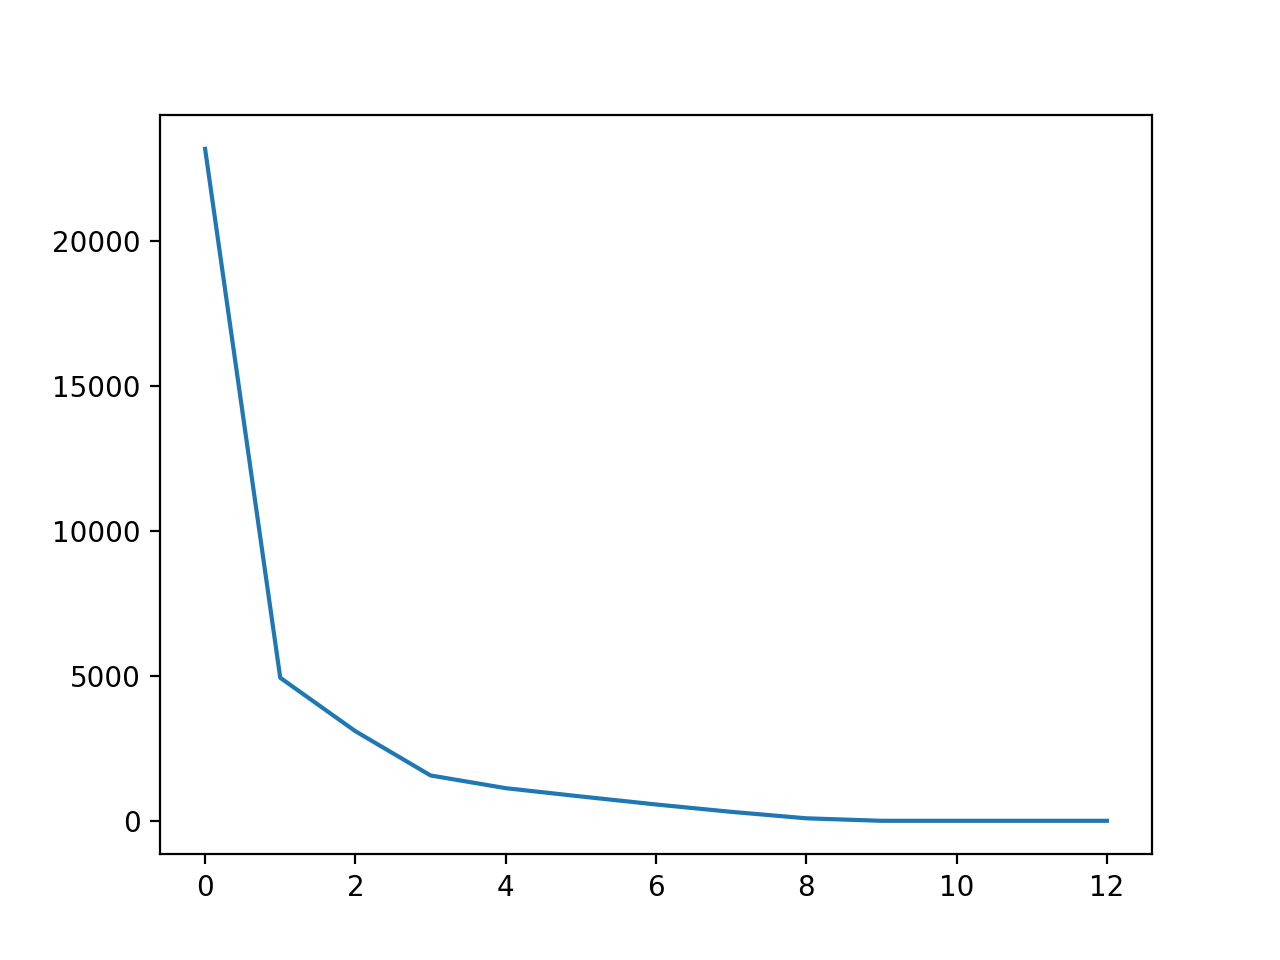

In [6]:
data_idx = 1
series = data[data_idx]

total = [sum(spec) for spec in series]
print(total[0:5])

plt.plot(total)
plt.show()

<IPython.core.display.Javascript object>


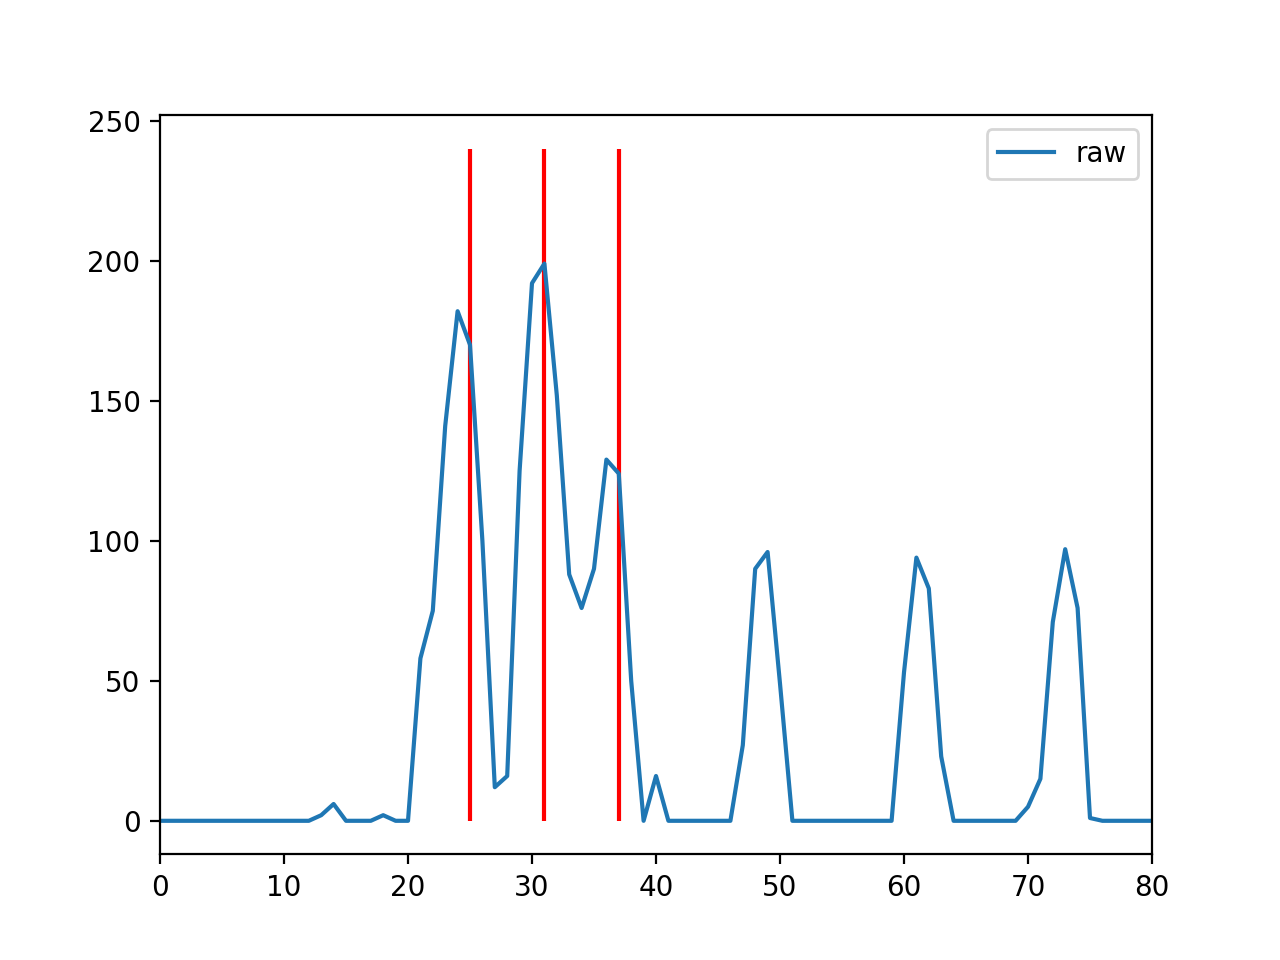

In [7]:
for n in range(-22, 88-5*12):
    chord = progression_truth[data_idx-1]
    #chord[2] -= 12
    col = "k"
    if n in chord:
        col = "r"
        # print(n, idx_for_freq(note_freqs(n)))
        plt.vlines(x=idx_for_freq(note_freqs(n)), ymin=0, ymax=240, color=col)
    
idx = 1

plt.plot(series[idx], label="raw")
# plt.plot(convolve(series[idx]))
plt.xlim([0, 80])
plt.legend()
plt.show()

In [8]:
exp_args = []
def exp(x, fast=False):
    if fast:
        return fast_exp(x)
    exp_args.append(x)
    return np.exp(x)

<IPython.core.display.Javascript object>


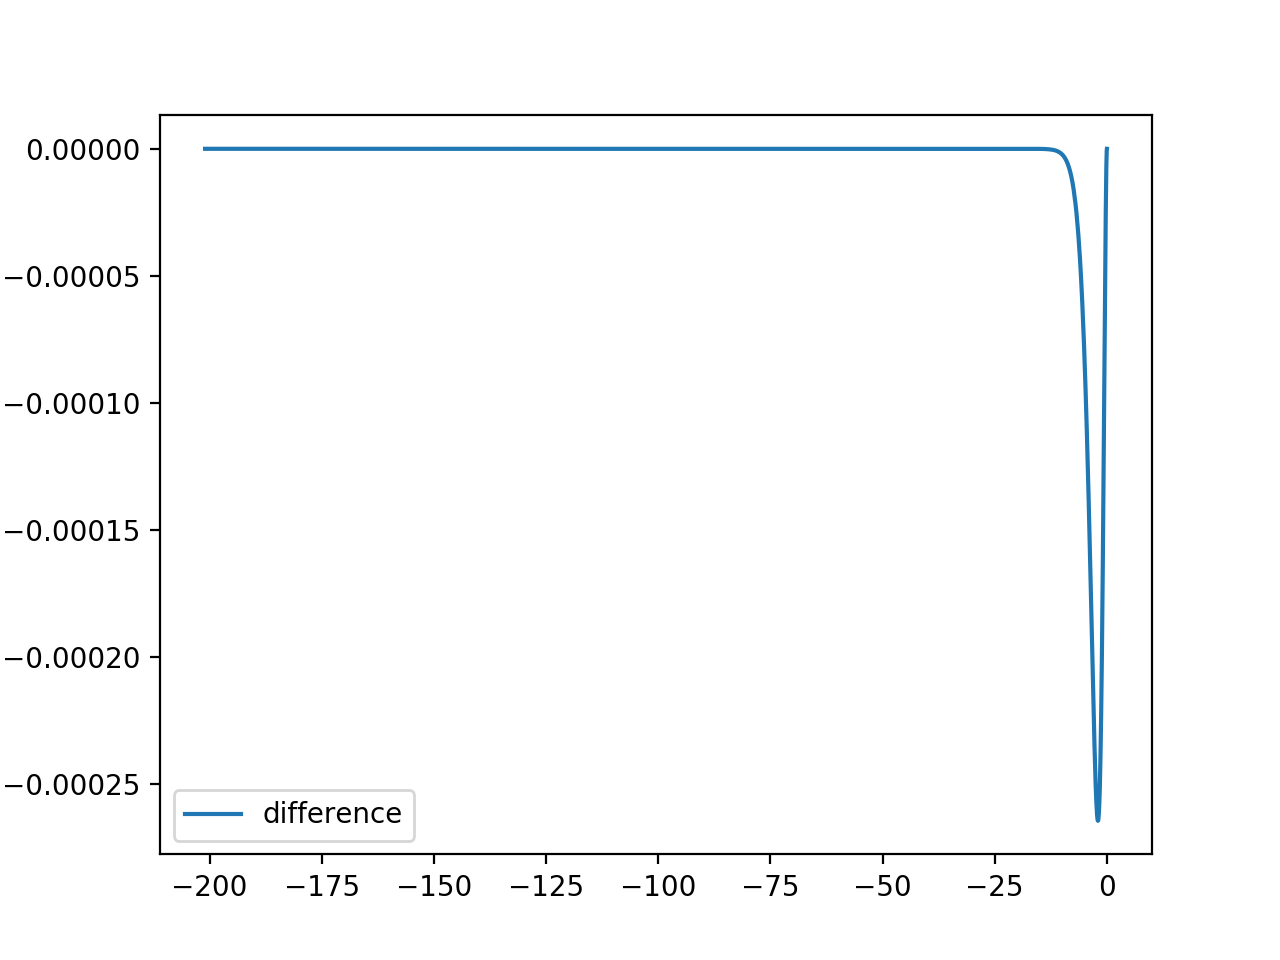

In [14]:
def fast_exp(x):
    x = 1.0 + x / 1024;
    x *= x; x *= x; x *= x; x *= x;
    x *= x; x *= x; x *= x; x *= x;
    x *= x; x *= x;
    return x;
exp_args.sort()
#plt.plot(exp_args, [np.exp(arg) for arg in exp_args], label="slow")
#plt.plot(exp_args, [fast_exp(arg) for arg in exp_args], label="fast")
plt.plot(exp_args, [fast_exp(arg)-np.exp(arg) for arg in exp_args], label="difference")
plt.legend()
plt.show()

In [9]:
# probability distributions

# on means power should be high
def prob_power_on(p, p_avg, p_max, lam=1):
    return lam * exp(-lam*(p_max-p)/p_avg)

def prob_power_off(p, p_avg, p_max, lam=1):
    return lam * exp(-lam*(p/p_avg))

# monotonus decrease was a fad ...

# is local max
def prob_max_on(p, p_l_max, lam=1):
    return lam * exp(-lam*abs(p-p_l_max))

def prob_max_off(p, p_l_max, lam=1):
    if p_l_max == p:
        return lam
    return lam * exp(-lam*1/abs(p-p_l_max))

# is proximal to global max (hands are not huge!)
# does what it should, but not very helpful ...
def prob_g_max_on(n, n_max, lam=0.5, m=5):
    return lam * exp(-lam*abs(n_max-n)/m)

def prob_g_max_off(n, n_max, lam=0.5, m=5):
    if n_max == n:
        return lam
    return lam * exp(-lam*m/abs(n_max-n))

def prob_on(p, p_avg, p_max, p_l_max, n, n_max):
    return prob_power_on(p, p_avg, p_max) * prob_max_on(p, p_l_max) * prob_g_max_on(n, n_max)

def prob_off(p, p_avg, p_max, p_l_max, n, n_max):
    return prob_power_off(p, p_avg, p_max) * prob_max_off(p, p_l_max) * prob_g_max_off(n, n_max)

In [10]:
# Algorithm sketch

def algo(in_stream, plot=False):
    buffer = []
    notes = [idx_for_freq(note_freqs(n)) for n in range(-22, 88-5*12)] # from lowest possible, to highest piano key
    total_prev = 0

    #in_stream = data[data_idx] # fake audio input stream
    want = [c+22 for c in progression_truth[data_idx-1]]
    # want = [c for c in want]

    for frame in in_stream:
        total = sum(frame)
        #if total > 2*total_prev:
            # start!
        buffer.append([frame[i] for i in notes])
        if len(buffer) == 3: # n frame buffer
            break
            
    # do bayes analysis
    prob = [0.5 for _ in range(-22, 88-5*12)]

    for idx in range(0, len(buffer)):
        p_max = max(buffer[idx])
        p_avg = sum(buffer[idx]) / len(buffer[idx])
        n_max = 0
        print(p_avg)
        
        ## CHANGE: skip avg === 0
        if p_avg == 0:
            break
        
        for n in range(0, len(buffer[idx])):
            if buffer[idx][n] == p_max:
                n_max = n
        for n in range(0, len(buffer[idx])):
            p = buffer[idx][n]
            p_l_max = max( buffer[idx][max(n-1, 0):min(n+2, len(buffer[idx]))] )
            p_given_on = prob_on(p, p_avg, p_max, p_l_max, n, n_max)
            p_given_off = prob_off(p, p_avg, p_max, p_l_max, n, n_max)
            # update
            prob[n] = prob[n] * p_given_on / (prob[n]*p_given_on + (1-prob[n])*p_given_off)
    
    if plot:
        plt.plot(prob, label=idx)
        plt.legend()
        for i in want:
            plt.vlines(x=i, ymin=0, ymax=max(prob)+0.2, color="r")
        plt.hlines(y=0.5, xmin=0, xmax=len(prob))
        #plt.plot(buffer[2])
        plt.show()
    
    return prob

131.82
39.12
27.42


<IPython.core.display.Javascript object>


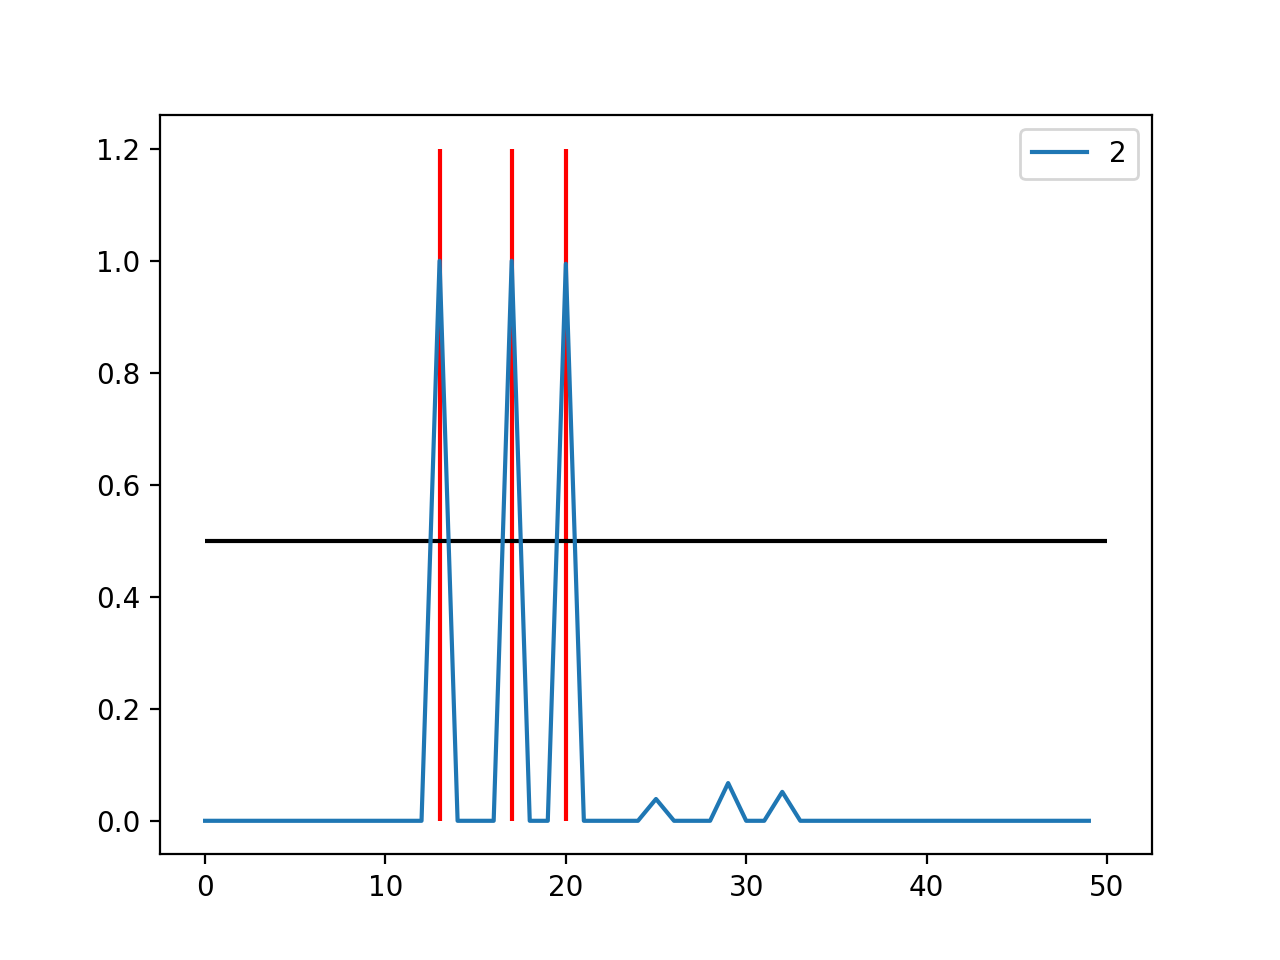

In [11]:
algo(data[data_idx], True);

In [12]:
# Try the data on the first 7 samples and see how they match
idx = 0
for (stream, truth) in zip(progression, progression_truth):
    pred = algo(stream)
    chord = []
    conf = []
    thresh = .6 # twiddle :)
    for note in range(len(pred)):
        if pred[note] > thresh:
            chord.append(note-22)
            conf.append(pred[note])
    idx += 1
    print("data_idx", idx)
    print("algo:", chord, conf)
    print("truth:", truth, [pred[c+22] for c in truth])
    print()

131.82
39.12
27.42
data_idx 1
algo: [-9, -5, -2] [0.9999911017459523, 0.999998120969136, 0.994625930770089]
truth: [-9, -5, -2] [0.9999911017459523, 0.999998120969136, 0.994625930770089]

123.22
41.16
24.86
data_idx 2
algo: [-7, -3, 0] [0.999844200539482, 0.9999997987041735, 0.9993401394399098]
truth: [-7, -3, 0] [0.999844200539482, 0.9999997987041735, 0.9993401394399098]

55.16
24.68
14.58
data_idx 3
algo: [-5, -1] [0.999999996545611, 0.9999999909629826]
truth: [-5, -1, 2] [0.999999996545611, 0.9999999909629826, 0.23691415184040168]

82.58
25.84
15.58
data_idx 4
algo: [-4, 0] [0.9999999984345097, 0.9999997383256364]
truth: [-4, 0, 3] [0.9999999984345097, 0.9999997383256364, 5.316336438072975e-05]

18.68
47.42
16.68
data_idx 5
algo: [-2] [0.9999946983324085]
truth: [-2, 2, 5] [0.9999946983324085, 0.00029122319884549255, 0.00010670854997862923]

0.0
data_idx 6
algo: [] []
truth: [0, 4, 7] [0.5, 0.5, 0.5]

4.92
0.0
data_idx 7
algo: [-9] [0.999999804392291]
truth: [2, 6, 9] [8.19505458125

## Notes

### Detect peaks
- simple a < b > c wont work...
  - need to use a convolution
  - convolution should be short and fall rapidly. maybe use 5 non-zero bins, with very steep gaussian
  
### Detect play
- total power spectrum has VERY noticable bump (!)
  - can probably just detect rising edges like that (where we go from 0 to > 5k or so ...)
  
### Detecting if note is played
- if it has consistently high power this is a good predictor
- (high power is power > 50 & > average (?))
- if the power is monotonously falling starting from the beginning, this is a good predictor

### Buffer length
- a 3 frame buffer should be enough (3/10 second response time, which is good(!)
- we only need to know the previous

### Overtones vs note:
- the high sample has the following problem: highest note is detected one octave too high
  - maybe there could be a rule that favours notes close to the global max?
- will include rule to surpress outlies, as that works much better with piano
  
### Note on C3 and below:
this is probably to low for us to resolve well with our transform

## Changes based on analysis
- should continously do edge detection. If we detect an edge, this overrides the previous data!